# Workbook for NLP Project

In [44]:
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import pandas as pd
from env import github_token, github_username

import prepare
import acquire

import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filter="ignore"

from bs4 import BeautifulSoup

## Data Acquisition

In [ ]:
#Acquire the URLS for the Repositories to explore

#headers = acquire.headers
#endpoint = "https://api.github.com/search/repositories"
#query = "customer in:name"
#sort = "stars"
#per_page = 100
#order = "desc"
#page = 1
#
##Make the request
#response = requests.get(f"{endpoint}?q={query}&sort={sort}&per_page={per_page}&order={order}&page={page}", headers=headers)
#payload = response.json()
#payload['items']

In [ ]:
#Convert the reponse to a data frame
#urls_df = pd.DataFrame(payload['items'])

In [ ]:
#Check the shape of the dataframe
#urls_df.shape

In [ ]:
#Get a list of the full_name for the urls
#urls_df.full_name.to_list()

In [2]:
#Use the scrape github function from the acquire module to acquire the dataframe containing the names of the
#repositories and the contents of the readme files
df = acquire.scrape_github_data()

#convert the data into a dataframe
df = pd.DataFrame(df)
df.head()

,repo,language,readme_contents
0,ansible/ansible,Python,|PyPI version| |Docs badge| |Chat badge| |Buil...
1,TensorSpeech/TensorFlowTTS,Python,"<h2 align=""center"">\n<p> :yum: TensorFlowTTS\n..."
2,plurals/pluralize,JavaScript,# Pluralize\n\n[![NPM version][npm-image]][npm...
3,vczh/tinymoe,C++,tinymoe\n=======\n### English-like programming...
4,RHVoice/RHVoice,C++,# RHVoice\n\nRHVoice is a free and open source...


In [3]:
df.shape

(284, 3)

---

## Data Preparation

In [4]:
#Determine if there are any null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             284 non-null    object
 1   language         263 non-null    object
 2   readme_contents  284 non-null    object
dtypes: object(3)
memory usage: 6.8+ KB


In [5]:
#Get Value counts for languages
df.language.value_counts()

Python                   58
JavaScript               42
PHP                      30
Java                     26
Jupyter Notebook         22
C#                       10
HTML                      9
Ruby                      8
C++                       7
Go                        6
TypeScript                5
Shell                     4
TeX                       4
C                         4
PowerShell                3
Common Lisp               3
R                         3
CSS                       3
Swift                     2
Scala                     1
Smalltalk                 1
Kotlin                    1
LilyPond                  1
XQuery                    1
Grammatical Framework     1
Rust                      1
OpenEdge ABL              1
Vue                       1
PLpgSQL                   1
VimL                      1
Julia                     1
Dart                      1
Roff                      1
Name: language, dtype: int64

In [6]:
#Drop null values
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 0 to 283
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             263 non-null    object
 1   language         263 non-null    object
 2   readme_contents  263 non-null    object
dtypes: object(3)
memory usage: 8.2+ KB


In [7]:
#Remove observations that have programming languages that appear less than 3 times

# Get the count of each value
value_counts = df['language'].value_counts()

# Select the values where the count is less than 7 
to_remove = value_counts[value_counts < 7].index

# Keep rows where the city column is not in to_remove
df = df[~df.language.isin(to_remove)]

#Check the value counts
df.language.value_counts()

Python              58
JavaScript          42
PHP                 30
Java                26
Jupyter Notebook    22
C#                  10
HTML                 9
Ruby                 8
C++                  7
Name: language, dtype: int64

In [8]:
#clean to hold the normalized and tokenized original with the stopwords removed.
df['clean'] = df['readme_contents'].apply(lambda x: prepare.remove_stopwords(prepare.tokenize(prepare.basic_clean(x))))

#stemmed to hold the stemmed version of the cleaned data.
df['stemmed'] = df['clean'].apply(lambda x: prepare.stem(x))

#lemmatized to hold the lemmatized version of the cleaned data.
df['lemmatized'] = df['clean'].apply(lambda x: prepare.lemmatize(x))

df

,repo,language,readme_contents,clean,stemmed,lemmatized
0,ansible/ansible,Python,|PyPI version| |Docs badge| |Chat badge| |Buil...,pypi version docs badge chat badge build statu...,pypi version doc badg chat badg build statu co...,pypi version doc badge chat badge build status...
1,TensorSpeech/TensorFlowTTS,Python,"<h2 align=""center"">\n<p> :yum: TensorFlowTTS\n...",h2 aligncenter p yum tensorflowtts p aligncent...,h2 aligncent p yum tensorflowtt p aligncent hr...,h2 aligncenter p yum tensorflowtts p aligncent...
2,plurals/pluralize,JavaScript,# Pluralize\n\n[![NPM version][npm-image]][npm...,pluralize npm versionnpmimagenpmurl npm downlo...,plural npm versionnpmimagenpmurl npm downloads...,pluralize npm versionnpmimagenpmurl npm downlo...
3,vczh/tinymoe,C++,tinymoe\n=======\n### English-like programming...,tinymoe englishlike programming language dsl d...,tinymo englishlik program languag dsl domain s...,tinymoe englishlike programming language dsl d...
4,RHVoice/RHVoice,C++,# RHVoice\n\nRHVoice is a free and open source...,rhvoice rhvoice free open source speech synthe...,rhvoic rhvoic free open sourc speech synthes f...,rhvoice rhvoice free open source speech synthe...
...,...,...,...,...,...,...
275,kpei/Customer-Analytics,Jupyter Notebook,# Customer Analytics iPython Notebook\nSee htt...,customer analytics ipython notebook see httpkp...,custom analyt ipython notebook see httpkpeimeb...,customer analytics ipython notebook see httpkp...
277,Sylius/CustomerOrderCancellationPlugin,PHP,"<p align=""center"">\n <a href=""https://syliu...",p aligncenter hrefhttpssyliuscom targetblank i...,p aligncent hrefhttpssyliuscom targetblank img...,p aligncenter hrefhttpssyliuscom targetblank i...
280,Azure/cortana-intelligence-customer360,Python,> **DISCLAIMER. Please note that this solution...,disclaimer please note solution longer support...,disclaim pleas note solut longer support feel ...,disclaimer please note solution longer support...
282,Sylius/CustomerReorderPlugin,PHP,"<p align=""center"">\n <a href=""https://syliu...",p aligncenter hrefhttpssyliuscom targetblank i...,p aligncent hrefhttpssyliuscom targetblank img...,p aligncenter hrefhttpssyliuscom targetblank i...


In [9]:
df.sample(10)

,repo,language,readme_contents,clean,stemmed,lemmatized
264,mceliksoy/CustomerDemo,JavaScript,Customers App is a full Ajax CRUD Rails applic...,customers app full ajax crud rails application...,custom app full ajax crud rail applic custom a...,customer app full ajax crud rail application c...
210,bradtraversy/restify_customer_api,JavaScript,# Restify Customer API\r\n\r\n> RESTful API bu...,restify customer api restful api built nodejs ...,restifi custom api rest api built nodej restif...,restify customer api restful api built nodejs ...
118,oligoglot/theedhum-nandrum,Python,# theedhum-nandrum (தீதும் நன்றும்)\nA sentime...,theedhumnandrum sentiment classifier mixed lan...,theedhumnandrum sentiment classifi mix languag...,theedhumnandrum sentiment classifier mixed lan...
20,speechio/BigCiDian,Python,# BigCiDian\n\n## 1. Goal\nThis project is an ...,bigcidian 1 goal project attempt create pronun...,bigcidian 1 goal project attempt creat pronunc...,bigcidian 1 goal project attempt create pronun...
275,kpei/Customer-Analytics,Jupyter Notebook,# Customer Analytics iPython Notebook\nSee htt...,customer analytics ipython notebook see httpkp...,custom analyt ipython notebook see httpkpeimeb...,customer analytics ipython notebook see httpkp...
220,IBM/customer-loyalty-program-hyperledger-fabri...,JavaScript,[![Build Status](https://travis-ci.org/IBM/cus...,build statushttpstravisciorgibmcustomerloyalty...,build statushttpstravisciorgibmcustomerloyalty...,build statushttpstravisciorgibmcustomerloyalty...
133,hci-lab/LearningMetersPoems,Jupyter Notebook,# Introduction\n\n1. This repo is our early re...,introduction 1 repo early research meter class...,introduct 1 repo earli research meter classif ...,introduction 1 repo early research meter class...
209,searobbersduck/CustomerServiceAI,Jupyter Notebook,# CustomerServiceAI\n智能客服\n\n## demo\n[一个客服系统的...,customerserviceai demo democandidateminingtest...,customerserviceai demo democandidateminingtest...,customerserviceai demo democandidateminingtest...
186,DanWahlin/CustomerManagerStandard,JavaScript,Customer Manager with AngularJS\r\n===========...,customer manager angularjs youre new angularjs...,custom manag angularj your new angularj check ...,customer manager angularjs youre new angularjs...
26,deep-diver/EN-FR-MLT-tensorflow,HTML,# MLT (EN to FR ) TensorFlow\n\nIn this projec...,mlt en fr tensorflow project going build langu...,mlt en fr tensorflow project go build languag ...,mlt en fr tensorflow project going build langu...


In [10]:
#Replace Jupyter Notebook in language with python
df.language = df.language.replace("Jupyter Notebook", "Python")

In [11]:
df.language.value_counts()

Python        80
JavaScript    42
PHP           30
Java          26
C#            10
HTML           9
Ruby           8
C++            7
Name: language, dtype: int64

In [12]:
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words]

In [13]:
def get_word_counts_by_language(df):
    
    languages = list(df.language.unique())
    
    word_counts = {}
    #language_cols = [language for language in languages + "_words"]
    
    for language in languages:
        language_words = clean(' '.join(df.lemmatized[df.language == language]))
        word_freq = pd.Series(language_words).value_counts()
        #word_freq = pd.DataFrame(word_freq)
        word_counts = {"words": language_words,
                      "language": word_freq}
        
    return word_counts
    
    

In [14]:
word_counts = get_word_counts_by_language(df)
word_counts

{'words': ['storevil',
  'natural',
  'language',
  'bdd',
  'framework',
  'net',
  'please',
  'see',
  'storevil',
  'wikihttpwikigithubcomdavidmfoleystorevil',
  'information',
  'mabipaker',
  'v2',
  'application',
  'tool',
  'import',
  'export',
  'client',
  'data',
  'file',
  'pack',
  'nexon',
  'online',
  'game',
  'mabinogi',
  'nexonmabinogipack',
  'build',
  'statushttpsciappveyorcomapiprojectsstatusqt0pq8t5ggcgu5m9svgtruehttpsciappveyorcomprojectloguemabipack',
  'infomation',
  'englishhttpsmabiassistloguebemabipacker',
  'httpsmabiassistloguebemabipackerja',
  'dependency',
  'mabinogiresourcehttpsgithubcomloguemabinogiresource',
  'license',
  'mitlicense',
  'baiduocrapi',
  'baidu',
  'offer',
  'powerful',
  'free',
  'ocr',
  'api',
  'ocrapi',
  'project',
  'basic',
  'ocr',
  'api',
  'test',
  'app',
  'visual',
  'studio',
  'c',
  'project',
  'source',
  'code',
  'also',
  'serf',
  'english',
  'language',
  'api',
  'documentation',
  'original',
  

In [ ]:
for language in languages:
    language_words = clean(' '.join(df.lemmatized[df.language == language]))
    word_freq = pd.Series(language_words).value_counts()

In [ ]:
word_freq = pd.DataFrame(word_freq)
word_freq

In [ ]:
#Create a list of the languages
languages = list(df.language.unique())
languages

In [15]:
df.language.value_counts()

Python        80
JavaScript    42
PHP           30
Java          26
C#            10
HTML           9
Ruby           8
C++            7
Name: language, dtype: int64

In [16]:
Python_words = clean(' '.join(df.clean[df.language == 'Python']))
JavaScript_words = clean(' '.join(df.clean[df.language == 'JavaScript']))
Cplusplus_words = clean(' '.join(df.clean[df.language == 'C++']))
PHP_words = clean(' '.join(df.clean[df.language == 'PHP']))
#CommonLisp_words = clean(' '.join(df.clean[df.language == 'Common Lisp']))
#C_words = clean(' '.join(df.clean[df.language == 'C']))
Ruby_words = clean(' '.join(df.clean[df.language == 'Ruby']))
HTML_words = clean(' '.join(df.clean[df.language == 'HTML']))
Java_words = clean(' '.join(df.clean[df.language == 'Java']))
Chash_words = clean(' '.join(df.clean[df.language == 'C#']))
#TeX_words = clean(' '.join(df.clean[df.language == 'TeX']))
#Go_words = clean(' '.join(df.clean[df.language == 'Go']))
#CSS_words = clean(' '.join(df.clean[df.language == 'CSS']))
#TypeScript_words = clean(' '.join(df.clean[df.language == 'TypeScript']))
#Shell_words = clean(' '.join(df.clean[df.language == 'Shell']))
#PowerShell_words = clean(' '.join(df.clean[df.language == 'PowerShell']))
#R_words = clean(' '.join(df.clean[df.language == 'R']))

In [17]:
Python_freq = pd.Series(Python_words).value_counts()
JavaScript_freq = pd.Series(JavaScript_words).value_counts()
Cplusplus_freq = pd.Series(Cplusplus_words).value_counts()
PHP_freq = pd.Series(PHP_words).value_counts()
#CommonLisp_freq = pd.Series(CommonLisp_words).value_counts()
#C_freq = pd.Series(C_words).value_counts()
Ruby_freq = pd.Series(Ruby_words).value_counts()
HTML_freq = pd.Series(HTML_words).value_counts()
Java_freq = pd.Series(Java_words).value_counts()
Chash_freq = pd.Series(Chash_words).value_counts()
#TeX_freq = pd.Series(TeX_words).value_counts()
#Go_freq = pd.Series(Go_words).value_counts()
#CSS_freq = pd.Series(CSS_words).value_counts()
#TypeScript_freq = pd.Series(TypeScript_words).value_counts()
#Shell_freq = pd.Series(Shell_words).value_counts()
#PowerShell_freq = pd.Series(PowerShell_words).value_counts()
#R_freq = pd.Series(R_words).value_counts()

In [18]:
#create a dataframe with all the wordcounts by category
word_counts = (pd.concat([Python_freq, JavaScript_freq, Cplusplus_freq, PHP_freq, 
                          Ruby_freq, HTML_freq, Java_freq, Chash_freq], axis=1, sort=True)
                .set_axis(['Python','JavaScript','Cplusplus','PHP_words','Ruby','HTML','Java',
                           'Chash'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,Python,JavaScript,Cplusplus,PHP_words,Ruby,HTML,Java,Chash
0,381,2,4,5,2,2,2,0
00,27,0,0,0,0,0,0,0
0000001,1,0,0,0,0,0,0,0
000001,1,0,0,0,0,0,0,0
000002,1,0,0,0,0,0,0,0


In [61]:
Python_words

['pypi',
 'version',
 'doc',
 'badge',
 'chat',
 'badge',
 'build',
 'status',
 'code',
 'conduct',
 'mailing',
 'list',
 'license',
 'cii',
 'best',
 'practice',
 'ansible',
 'ansible',
 'radically',
 'simple',
 'automation',
 'system',
 'handle',
 'configuration',
 'management',
 'application',
 'deployment',
 'cloud',
 'provisioning',
 'adhoc',
 'task',
 'execution',
 'network',
 'automation',
 'multinode',
 'orchestration',
 'ansible',
 'make',
 'complex',
 'change',
 'like',
 'zerodowntime',
 'rolling',
 'update',
 'load',
 'balancer',
 'easy',
 'information',
 'ansible',
 'website',
 'httpsansiblecom',
 'design',
 'principle',
 'deadsimple',
 'setup',
 'process',
 'minimal',
 'learning',
 'curve',
 'manage',
 'machine',
 'quickly',
 'parallel',
 'avoid',
 'customagents',
 'additional',
 'open',
 'port',
 'agentless',
 'leveraging',
 'existing',
 'ssh',
 'daemon',
 'describe',
 'infrastructure',
 'language',
 'machine',
 'human',
 'friendly',
 'focus',
 'security',
 'easy',
 'audi

In [19]:
word_counts.sample(20)

,Python,JavaScript,Cplusplus,PHP_words,Ruby,HTML,Java,Chash
mark,18,0,1,1,1,0,1,0
retrieve,0,1,0,1,0,0,3,0
proofread,1,0,0,0,0,0,0,0
wmlauthtoken,2,0,0,0,0,0,0,0
httpdocscythonorgsrcquickstartinstallhtml,1,0,0,0,0,0,0,0
settingsyml,0,0,0,1,0,0,0,0
printlistkuhemwarkualphabetar,1,0,0,0,0,0,0,0
inproceedingsbhat2014iss28248642824872,1,0,0,0,0,0,0,0
deepsrl,1,0,0,0,0,0,0,0
midnight,0,0,0,0,0,0,2,0


---

## Exploration

**Python**

In [20]:
#Create a bigram of words
top_15_Python_bigrams = (pd.Series(nltk.ngrams(Python_words, 2)).value_counts().head(15))

top_15_Python_bigrams

(9, 9)                    469
(0, 0)                    209
(0, 1)                     80
(1, 0)                     73
(arabic, letter)           67
(pip, install)             57
(machine, learning)        44
(w, 9)                     42
(9, w)                     39
(latin, capital)           34
(capital, letter)          34
(cloud, pak)               33
(arabicbased, kurdish)     28
(pak, data)                26
(spacy, model)             24
dtype: int64

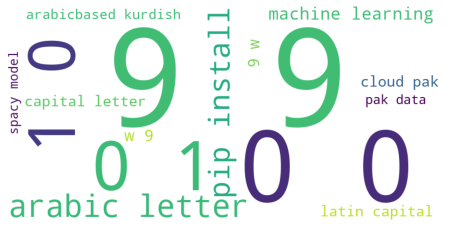

In [21]:
#Create a wordcloud of the blog bigrams
data = {k[0] + ' ' + k[1]: v for k, v in top_15_Python_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [22]:
Python_words

['pypi',
 'version',
 'doc',
 'badge',
 'chat',
 'badge',
 'build',
 'status',
 'code',
 'conduct',
 'mailing',
 'list',
 'license',
 'cii',
 'best',
 'practice',
 'ansible',
 'ansible',
 'radically',
 'simple',
 'automation',
 'system',
 'handle',
 'configuration',
 'management',
 'application',
 'deployment',
 'cloud',
 'provisioning',
 'adhoc',
 'task',
 'execution',
 'network',
 'automation',
 'multinode',
 'orchestration',
 'ansible',
 'make',
 'complex',
 'change',
 'like',
 'zerodowntime',
 'rolling',
 'update',
 'load',
 'balancer',
 'easy',
 'information',
 'ansible',
 'website',
 'httpsansiblecom',
 'design',
 'principle',
 'deadsimple',
 'setup',
 'process',
 'minimal',
 'learning',
 'curve',
 'manage',
 'machine',
 'quickly',
 'parallel',
 'avoid',
 'customagents',
 'additional',
 'open',
 'port',
 'agentless',
 'leveraging',
 'existing',
 'ssh',
 'daemon',
 'describe',
 'infrastructure',
 'language',
 'machine',
 'human',
 'friendly',
 'focus',
 'security',
 'easy',
 'audi

**JavaScript**

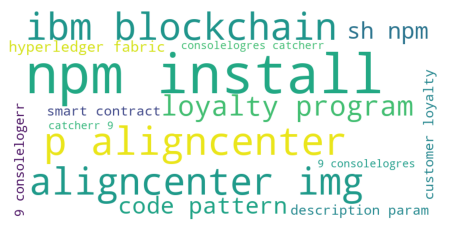

In [23]:
#Create a bigram of words
top_15_JS_bigrams = (pd.Series(nltk.ngrams(JavaScript_words, 2)).value_counts().head(15))

#Create a wordcloud of the blog bigrams
data = {k[0] + ' ' + k[1]: v for k, v in top_15_JS_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

**Java**

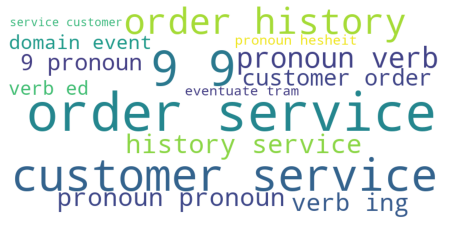

In [24]:
#Create a bigram of words
top_15_Java_bigrams = (pd.Series(nltk.ngrams(Java_words, 2)).value_counts().head(15))

#Create a wordcloud of the blog bigrams
data = {k[0] + ' ' + k[1]: v for k, v in top_15_Java_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

## Modeling

**Split the Data into Train, Validate, Test**

In [25]:
# We'll use this split function later to create in-sample and out-of-sample datasets for modeling
def split(df, stratify_by=None):
    """
    3 way split for train, validate, and test datasets
    To stratify, send in a column name
    """
    
    
    train, test = train_test_split(df, test_size=.2, random_state=123, stratify=df[stratify_by])
    
    train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train[stratify_by])
    
    return train, validate, test

In [26]:
#Split the data and stratify by language
train, validate, test = split(df, 'language')
train.shape

(118, 6)

In [27]:
# Setup our X variables
X_train = train.lemmatized
X_validate = validate.lemmatized
X_test = test.lemmatized

# Setup our y variables
y_train = train.language
y_validate = validate.language
y_test = test.language

**Establish A Baseline**

In [28]:
#Establish baseline
df.language.value_counts()

Python        80
JavaScript    42
PHP           30
Java          26
C#            10
HTML           9
Ruby           8
C++            7
Name: language, dtype: int64

**Baseline Prediction = Python**

In [29]:
print(f'Baseline Accuracy: {round(80 / df.shape[0] *100)}%')

Baseline Accuracy: 38%


---

**Vectorize the Data**

In [30]:
#Create the tfidf vectorizer object
tfidf = TfidfVectorizer()

#Fit the object on the training data
tfidf.fit(X_train)

#Use the object
X_train_vectorized =tfidf.transform(X_train)
X_validate_vectorized =tfidf.transform(X_validate) 
X_test_vectorized =tfidf.transform(X_test)

**Logistic Regression Model**

In [31]:
#Using the vectorized data, make a logistic regression model
lm = LogisticRegression()

#Fit the lm object to the vectorized data
lm.fit(X_train_vectorized, y_train)

#Create corresponding dataframes for the actual values of the categories that correspond to each article
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

#Form predictions uisng the lm model
train['predicted'] = lm.predict(X_train_vectorized)
validate["predicted"] = lm.predict(X_validate_vectorized)
test['predicted'] = lm.predict(X_test_vectorized)

#Review how the lm model performed on the in-sample data
print(classification_report(train.actual, train.predicted, zero_division=0))

              precision    recall  f1-score   support

          C#       0.00      0.00      0.00         5
         C++       0.00      0.00      0.00         4
        HTML       0.00      0.00      0.00         5
        Java       1.00      0.60      0.75        15
  JavaScript       1.00      0.96      0.98        23
         PHP       1.00      0.88      0.94        17
      Python       0.62      1.00      0.77        45
        Ruby       0.00      0.00      0.00         4

    accuracy                           0.77       118
   macro avg       0.45      0.43      0.43       118
weighted avg       0.70      0.77      0.71       118



/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
#Review how the lm model performed on the out-of-sample data
print(classification_report(validate.actual, validate.predicted))

              precision    recall  f1-score   support

          C#       0.00      0.00      0.00         3
         C++       0.00      0.00      0.00         2
        HTML       0.00      0.00      0.00         2
        Java       0.00      0.00      0.00         6
  JavaScript       0.75      0.30      0.43        10
         PHP       1.00      0.57      0.73         7
      Python       0.44      1.00      0.61        19
        Ruby       0.00      0.00      0.00         2

    accuracy                           0.51        51
   macro avg       0.27      0.23      0.22        51
weighted avg       0.45      0.51      0.41        51



**Takeaways:**
- Logistic regression model performs better than baseline with an accuracy of We 51% on out-of-sample data
- LM model os most accurate for predicting languages that are JavaScript, PHP & Python. 

---

**KNN Model**

In [41]:
#Create the KNN object with a k = 10
knn = KNeighborsClassifier(n_neighbors=10, weights='uniform')

#Fit the object to the vectorized training data
knn.fit(X_train_vectorized, y_train)

#Create corresponding dataframes for the actual values of the categories that correspond to each article
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

#Form predictions uisng the knn model
train['predicted'] = knn.predict(X_train_vectorized)
validate["predicted"] = knn.predict(X_validate_vectorized)
test['predicted'] = knn.predict(X_test_vectorized)

#Review how the knn model performed on the in-sample data
print(classification_report(train.actual, train.predicted))

#Review how the knn model performed on the out-of-sample data
print(classification_report(validate.actual, validate.predicted, zero_division=0))

              precision    recall  f1-score   support

          C#       0.00      0.00      0.00         5
         C++       0.00      0.00      0.00         4
        HTML       0.00      0.00      0.00         5
        Java       0.40      0.53      0.46        15
  JavaScript       0.60      0.65      0.63        23
         PHP       0.87      0.76      0.81        17
      Python       0.71      0.91      0.80        45
        Ruby       0.00      0.00      0.00         4

    accuracy                           0.65       118
   macro avg       0.32      0.36      0.34       118
weighted avg       0.56      0.65      0.60       118

              precision    recall  f1-score   support

          C#       0.00      0.00      0.00         3
         C++       0.00      0.00      0.00         2
        HTML       0.00      0.00      0.00         2
        Java       0.33      0.17      0.22         6
  JavaScript       0.55      0.60      0.57        10
         PHP       0.60 

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Takeaways:**

---

**Random Forest Model**

In [38]:
#Create the RF object
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=2,
                            n_estimators=100,
                            max_depth=15, 
                            random_state=123)

#Fit the RF object to the training data
rf.fit(X_train_vectorized, y_train)

#Predict on y
y_pred = rf.predict(X_train_vectorized)

#Evaluate
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          C#       1.00      0.60      0.75         5
         C++       1.00      0.50      0.67         4
        HTML       1.00      0.40      0.57         5
        Java       1.00      0.73      0.85        15
  JavaScript       1.00      0.78      0.88        23
         PHP       1.00      1.00      1.00        17
      Python       0.73      1.00      0.84        45
        Ruby       1.00      0.75      0.86         4

    accuracy                           0.86       118
   macro avg       0.97      0.72      0.80       118
weighted avg       0.90      0.86      0.85       118



In [39]:
#Predict using out of sample data
y_pred = rf.predict(X_validate_vectorized)

print(classification_report(y_validate, y_pred, zero_division=0))

              precision    recall  f1-score   support

          C#       0.00      0.00      0.00         3
         C++       0.00      0.00      0.00         2
        HTML       0.00      0.00      0.00         2
        Java       0.00      0.00      0.00         6
  JavaScript       0.67      0.60      0.63        10
         PHP       1.00      0.57      0.73         7
      Python       0.50      1.00      0.67        19
        Ruby       0.00      0.00      0.00         2

    accuracy                           0.57        51
   macro avg       0.27      0.27      0.25        51
weighted avg       0.45      0.57      0.47        51



/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Takeaways:**

---

**Decision Tree**

In [56]:
#Make the CLF object
clf = DecisionTreeClassifier(max_depth=9, random_state=123)

#Fit the model on the training set 
clf = clf.fit(X_train_vectorized, y_train)

#Make predictions
y_pred = clf.predict(X_train_vectorized)

#Evaluate model performance on training data
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          C#       1.00      0.60      0.75         5
         C++       1.00      0.50      0.67         4
        HTML       1.00      0.80      0.89         5
        Java       1.00      0.80      0.89        15
  JavaScript       1.00      0.83      0.90        23
         PHP       1.00      1.00      1.00        17
      Python       0.79      1.00      0.88        45
        Ruby       1.00      1.00      1.00         4

    accuracy                           0.90       118
   macro avg       0.97      0.82      0.87       118
weighted avg       0.92      0.90      0.90       118



In [59]:
# Predict on validate
y_pred = clf.predict(X_validate_vectorized)

# Evaluate model performance on out-of-sample data
print(classification_report(y_validate, y_pred, zero_division=0))

              precision    recall  f1-score   support

          C#       0.00      0.00      0.00         3
         C++       0.00      0.00      0.00         2
        HTML       0.00      0.00      0.00         2
        Java       0.40      0.33      0.36         6
  JavaScript       0.75      0.90      0.82        10
         PHP       0.83      0.71      0.77         7
      Python       0.62      0.84      0.71        19
        Ruby       0.00      0.00      0.00         2

    accuracy                           0.63        51
   macro avg       0.32      0.35      0.33        51
weighted avg       0.54      0.63      0.57        51

